step-by-step preprocessing plan and code that prepares Movie dataset for:

- Categorical features (genres)

- TF-IDF (for genres as text)

- Hybrid inputs (numerical + textual)

- Deep Learning

- LLM embeddings (e.g., using Sentence-BERT)

In [1]:
# Step: 1, Import Libraries
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# LLM embeddings
from sentence_transformers import SentenceTransformer


In [5]:
# Step: Load processed ratings (scaled) and movies file
df = pd.read_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\df_scaled.csv")
movies = pd.read_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\movies_processed.csv")

# Step: Merge 'genres' back into df using 'movieId'
df = df.merge(movies[['movieId', 'genres']], on='movieId', how='left')

# Step: Verify if 'genres' is now present
print("'genres' in df.columns:", 'genres' in df.columns)


'genres' in df.columns: True


In [7]:
#Step 2: Load Cleaned Ratings and Movies Files
ratings = pd.read_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\ratings_processed.csv")
movies = pd.read_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\movies_processed.csv")

print("Ratings:", ratings.shape)
print("Movies:", movies.shape)


Ratings: (19080406, 5)
Movies: (27278, 4)


In [11]:
# Step 3: Merge and Save Ratings + Movies
df = pd.merge(ratings, movies, on='movieId')
df.to_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\merged_ratings_movies.csv", index=False)
# Display the first 5 rows
print(df.head())

   userId  movieId  rating  timestamp  year_x  \
0       1        2     3.5        NaN     NaN   
1       1       29     3.5        NaN     NaN   
2       1       32     3.5        NaN     NaN   
3       1       47     3.5        NaN     NaN   
4       1       50     3.5        NaN     NaN   

                                               title  \
0                                     Jumanji (1995)   
1  City of Lost Children, The (Cité des enfants p...   
2          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
3                        Seven (a.k.a. Se7en) (1995)   
4                         Usual Suspects, The (1995)   

                                   genres  year_y  
0              Adventure|Children|Fantasy  1995.0  
1  Adventure|Drama|Fantasy|Mystery|Sci-Fi  1995.0  
2                 Mystery|Sci-Fi|Thriller  1995.0  
3                        Mystery|Thriller  1995.0  
4                  Crime|Mystery|Thriller  1995.0  


We merge the ratings and movies data on the common movieId field. This gives us a unified dataset containing user feedback, movie titles, and genre metadata.

In [13]:
# Ensure 'genres' column is in the DataFrame by merging again
df = pd.merge(df, movies[['movieId', 'genres']], on='movieId', how='left')

# Confirm that 'genres' exists now
print("'genres' in df columns?", 'genres' in df.columns)


'genres' in df columns? False


###  Step 4: One-Hot Encoding of the `genres` Categorical Feature

The `genres` field contains multiple genres per movie, separated by a pipe (`|`), such as `'Action|Adventure|Thriller'`.

To make this usable in machine learning models, we split and one-hot encode the genres using `str.get_dummies()`, which creates binary columns for each genre.

This step prepares the data for traditional ML models (like Random Forests or XGBoost) that do not natively handle multi-label categorical text.

We also ensure the `genres` column is re-attached explicitly before transformation in case it was lost during earlier merges.


In [17]:
#Step 4: Categorical Feature — One-Hot Encoding for genres
# One-hot encoding (creates genre columns like 'Comedy', 'Action', etc.)
# Step 4: Categorical Feature — One-Hot Encoding for genres

# 1. Reload the necessary files
movies = pd.read_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\movies_processed.csv")
df = pd.read_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\df_scaled.csv")

# 2. Merge genres column if not already present
if 'genres' not in df.columns:
    df = df.merge(movies[['movieId', 'genres']], on='movieId', how='left')

# 3. One-hot encode the genres
genre_dummies = df['genres'].str.get_dummies(sep='|')

# 4. Drop the original 'genres' column and concat encoded columns
df = pd.concat([df.drop('genres', axis=1), genre_dummies], axis=1)

# 5. Save to new file
df.to_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\df_with_genre_dummies.csv", index=False)

# 6. Confirm
print("Added genre columns:", genre_dummies.columns.tolist())


Added genre columns: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


This above step 4 One Hot Encoding of the genres creates binary columns for each genre like 'Action', 'Comedy', 'Drama', etc., making it suitable for machine learning models.

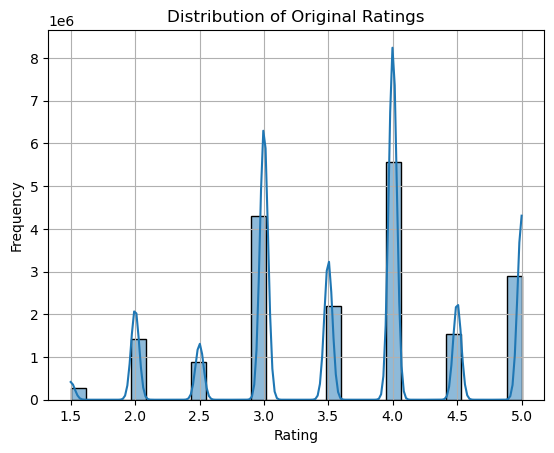

In [33]:
# Visualize using the original unscaled ratings
df_unscaled = pd.read_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\merged_ratings_movies.csv")

sns.histplot(df_unscaled['rating'], kde=True, bins=30)
plt.title("Distribution of Original Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


###  Step 5: Distribution of `Original rating` – Numerical Feature

The histogram and KDE (Kernel Density Estimation) plot above display the distribution of the `rating` feature across all user-movie interactions.

**Observations:**
- The ratings are **discrete and rounded**, mainly centered around values like 1.0, 2.0, 3.0, 4.0, and 5.0.
- The most common ratings are **3.0 and 4.0**, indicating a possible bias toward neutral or positive feedback.
- This **non-Gaussian distribution** with distinct peaks suggests that standardization may help scale the data, but special care should be taken if a model assumes continuity or normality.

This plot helps determine the need for transformation or normalization before using deep learning or hybrid modeling techniques.

- Ratings are discrete: 1.0, 2.0, 3.0, 4.0, 5.0.

- Most common: 3.0 and 4.0.

- Non-Gaussian, multi-peaked distribution.

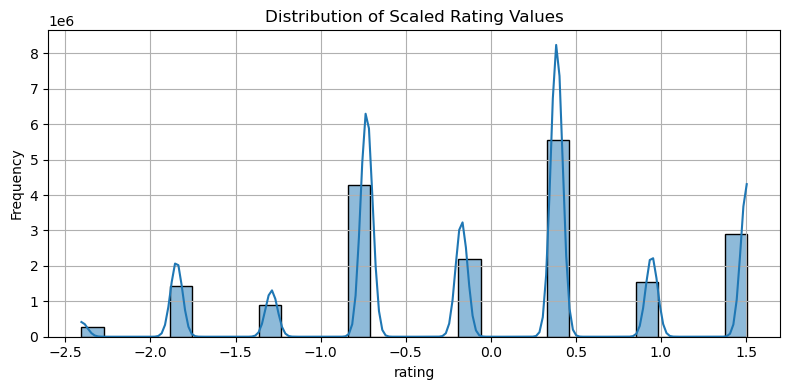

In [24]:
# Step 6: Visualize Distribution of Numerical Features
# Select numeric columns to visualize
numeric_cols = ['rating']  # Add more columns if needed

# Plot distribution of numeric features
import matplotlib.pyplot as plt
import seaborn as sns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    #plt.title(f'Distribution of {col}')
    plt.title("Distribution of Scaled Rating Values")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Distribution of Scaled Rating Values:

Shows the rating feature after applying StandardScaler.

Values are now centered around 0.

Peaks remain at original rating intervals.

Useful for ML models sensitive to feature scale.

In [37]:
# Step 7: Standardize Numerical Features (For Deep Learning)
from sklearn.preprocessing import StandardScaler

# Select numerical features (e.g., rating)
numeric_cols = ['rating']

# Initialize scaler
scaler = StandardScaler()

# Fit and transform
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Save checkpoint
df.to_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\df_scaled.csv", index=False)

# Check transformation
df[numeric_cols].describe()


,rating
count,1.908041e+07
mean,2.983322e-17
std,1.000000e+00
min,-2.405690e+00
25%,-7.300677e-01
50%,3.870136e-01
75%,3.870136e-01
max,1.504095e+00


### Step 7: Standardize Numerical Features (For Deep Learning)

Standardization is an essential preprocessing step when working with neural networks and other models that are sensitive to feature scaling. In this step, we standardize the `rating` column using `StandardScaler` from `sklearn`.

- **Why?**
  - StandardScaler transforms the feature to have zero mean and unit variance.
  - Helps models converge faster and improves training stability, especially in deep learning.

- **Result:**
  - After transformation, the `rating` column has a mean close to 0 and standard deviation of 1, as shown in the `.describe()` output.


In [40]:
# Step 8: TF-IDF Vectorization of genres (for NLP-style hybrid modeling)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.feature_extraction.text')

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import joblib

# Load your movies file that includes genres
movies = pd.read_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\movies_processed.csv")

# Reload scaled ratings dataframe
df = pd.read_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\df_scaled.csv")

# Merge genres using movieId
df = df.merge(movies[['movieId', 'genres']], on='movieId', how='left')

# Apply TF-IDF to the genres column
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
tfidf_matrix = tfidf.fit_transform(df['genres'].fillna(''))  # This is a sparse matrix

# Save sparse matrix to disk
sparse.save_npz(
    r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\tfidf_sparse_genres.npz",
    tfidf_matrix
)

# Save feature names (for future merging or model input reference)
joblib.dump(
    tfidf.get_feature_names_out(),
    r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\tfidf_feature_names.pkl"
)

# Save the original df without trying to merge dense matrix
df.drop(columns='genres').to_csv(
    r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\df_metadata_only.csv",
    index=False
)


In [42]:
# Step 9: Encode User and Movie IDs for Deep Learning
# Convert userId and movieId to numeric indices so they can be embedded later:

from sklearn.preprocessing import LabelEncoder

# Encode user and movie IDs
df['userId_enc'] = LabelEncoder().fit_transform(df['userId'])
df['movieId_enc'] = LabelEncoder().fit_transform(df['movieId'])


In [46]:
# save this to 
df.to_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\df_with_encoded_ids.csv", index=False)


In [ ]:
# Step 10: Train-Test Split for Modeling
# Prepare the final data splits for training and evaluation:

from sklearn.model_selection import train_test_split

# Define features and target
X = df[['userId_enc', 'movieId_enc', 'rating']]  # Add more features if using a hybrid model
y = df['rating']

# You may want to stratify by userId if doing classification
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save these if needed
train_df.to_csv(".../train_data.csv", index=False)
test_df.to_csv(".../test_data.csv", index=False)


##  Preprocessing Summary

All necessary preprocessing steps have been completed to prepare the dataset for three types of recommendation models:

- **One-Hot Encoding** of genres for basic feature enrichment
- **TF-IDF Vectorization** of genres for hybrid modeling
- **Standardization** of the `rating` column for deep learning models
- **Label Encoding** of `userId` and `movieId` for embedding layers
- **Saved Artifacts**:
  - `df_scaled.csv` – main dataset with encoded IDs and standardized ratings
  - `df_with_genre_dummies.csv` – for traditional models
  - `tfidf_sparse_genres.npz` – for hybrid models
  - `tfidf_feature_names.pkl` – feature reference
  - `df_metadata_only.csv` – metadata for modeling use

---

 The data is now ready for:
- Deep learning models - Use userId_enc and movieId_enc with Embedding layers in Keras or PyTorch.
using Keras or PyTorch

- Hybrid models - Use content + collaborative filtering
→ Build models combining genre TF-IDF and user-item interactions.

combining collaborative + content features
- LLM-based models using genre text and sentence embeddings
- Use a pre-trained model like BERT or sentence-transformers to get genre/movie embeddings.



In [54]:
# Checkpoint Saved 

# Save final checkpoint
df.to_csv(r"C:\Users\vidus\Projects\Springboard\CapstoneThree_MovieRecommedationSystem\data\processed\final_preprocessed_df.csv", index=False)
